# the source code for the publication in IEEE TAI
## Xiao, B., Lam, H.K., Xuan, C., Wang, Z. and Yeatman, E.M., 2022. Optimization for Interval Type-2 Polynomial Fuzzy Systems: A Deep Reinforcement Learning Approach. *IEEE Transactions on Artificial Intelligence*.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from scipy.integrate import odeint
from numpy.linalg import multi_dot
from collections import namedtuple
import random
#from controlfunx import numerical_model_simu_plain, control_simu_plain
import seaborn as sns; sns.set()
from PIL import Image

def numerical_model_simu_plain(x, t, a):
    G1 = np.array([22.0220, -0.4502]).reshape(1, 2)
    G2 = np.array([11.2020, 4.9780]).reshape(1, 2)

    x1, x2 = x

    A1 = np.array([[5.59 + 0.45 * np.power(x1, 2), -7.92 - 0.89 * x1], [5.01, -1.1 - 0.27 * np.power(x1, 2)]])
    A2 = np.array([[4.02 - 0.26 * x1 - 0.05 * np.power(x1, 2), -4.64 + 0.72 * x1], [4.35, -2.56]])
    A3 = np.array([[8.23 + 0.45 * np.power(x1, 2), 8.45 + 2.13 * x1], [3.1 + 1.77 * x1, -3.5 - np.power(x1, 2)]])

    B1 = np.array([[-0.128 * np.power(x1, 2) + 0.037 * x1 - 0.1], [-0.4]])
    B2 = np.array([[-0.088 * np.power(x1, 2) + 0.023 * x1 - 0.8], [0.1]])
    B3 = np.array([[-0.155 * np.power(x1, 2) + 0.073 * x1 - 1.4], [0.1]])

    lamb1l = (np.sin(5 * x1) + 1) / 2
    lamb1u = 1 - lamb1l

    lamb3l = (np.cos(5 * x1) + 1) / 2
    lamb3u = 1 - lamb3l

    w1l = 1 - 1 / (1 + np.exp(-x1 - 3.2))
    w1u = 1 - 1 / (1 + np.exp(-x1 - 2.8))

    w3l = 1 - 1 / (1 + np.exp(-x1 + 3.2))
    w3u = 1 - 1 / (1 + np.exp(-x1 + 2.8))

    w1 = lamb1l * w1l + lamb1u * w1u
    w3 = lamb3l * w3l + lamb3u * w3u

    w2 = 1 - w1 - w3

    m1l = np.maximum(np.minimum(1, (3.5 - x1) / 10), 0)
    m1u = np.maximum(np.minimum(1, (6.5 - x1) / 10), 0)

    m1 = m1l + (m1u - m1l) * a
    m2 = 1 - m1

    u = (m1 * np.matmul(G1, x)) + (m2 * np.matmul(G2, x))

    dx = w1 * (np.matmul(A1, x) + np.matmul(B1, u)) + w2 * (np.matmul(A2, x) + np.matmul(B2, u)) + w3 * (
                np.matmul(A3, x) +
                np.matmul(B3, u))
    return dx


def control_simu_plain(x_array, a):
    G1 = np.array([22.0220, -0.4502]).reshape(1, 2)
    G2 = np.array([11.2020, 4.9780]).reshape(1, 2)

    u_array = []
    for i in range(x_array.shape[0]):
        x1, x2 = x_array[i, :]

        x = np.array([x1, x2]).reshape(2, 1)

        m1l = np.maximum(np.minimum(1, (3.5 - x1) / 10), 0)
        m1u = np.maximum(np.minimum(1, (6.5 - x1) / 10), 0)

        m1 = m1l + (m1u - m1l) * a
        m2 = 1 - m1

        u = (m1 * np.matmul(G1, x)) + (m2 * np.matmul(G2, x))
        u_array = np.append(u_array, u)

    return u_array

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


def fanin_init(size, fanin=None):
    """
    weight initializer known from https://arxiv.org/abs/1502.01852
    :param size:
    :param fanin:
    :return:
    """
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2 = nn.Linear(20, 30)
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3 = nn.Linear(30, 1)
        self.fc3.weight.data = fanin_init(self.fc3.weight.data.size())

    def forward(self, x):
         x = torch.tanh(self.fc1(x))
         x = F.relu(self.fc2(x))
         x = torch.sigmoid(self.fc3(x))
         return x

class CriticNet(nn.Module):
    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc1 = nn.Linear(3, 30)
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2 = nn.Linear(30, 50)
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3 = nn.Linear(50, 1)
        self.fc3.weight.data.uniform_(-0.03, 0.03)

    def forward(self, x):
         x = F.relu(self.fc1(x))
         x = torch.sigmoid(self.fc2(x))
         x = self.fc3(x)
         return x

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.position = 0
        self.memory = []

    def __len__(self):
        return len(self.memory)

    def push(self, *args):
        if len(self) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = self.position + 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __repr__(self):
        return 'Memory[0:%r]' % self.position


def numerical_model(x, t, a):

    G1 = np.array([22.0220,  -0.4502]).reshape(1, 2)
    G2 = np.array([11.2020, 4.9780]).reshape(1, 2)

    x1, x2 = x
    A1 = np.array([[5.59 + 0.45*np.power(x1, 2), -7.92 - 0.89*x1], [5.01, -1.1 - 0.27*np.power(x1, 2)]])
    A2 = np.array([[4.02 - 0.26*x1 -0.05*np.power(x1, 2), -4.64 + 0.72*x1], [4.35, -2.56]])
    A3 = np.array([[8.23 + 0.45*np.power(x1, 2), 8.45 + 2.13*x1], [3.1 + 1.77*x1, -3.5 - np.power(x1, 2)]])

    B1 = np.array([[-0.128*np.power(x1, 2) + 0.037*x1 -0.1],[-0.4]])
    B2 = np.array([[-0.088*np.power(x1, 2) + 0.023*x1 -0.8],[0.1]])
    B3 = np.array([[-0.155*np.power(x1, 2) + 0.073*x1 -1.4],[0.1]])

    lamb1l = (np.sin(5*x1) + 1) / 2
    lamb1u = 1 - lamb1l

    lamb3l = (np.cos(5 * x1) + 1) / 2
    lamb3u = 1 - lamb3l

    w1l = 1 - 1 / (1 + np.exp(-x1 - 3.2))
    w1u = 1 - 1 / (1 + np.exp(-x1 - 2.8))

    w3l = 1 - 1 / (1 + np.exp(-x1 + 3.2))
    w3u = 1 - 1 / (1 + np.exp(-x1 + 2.8))

    w1 = lamb1l * w1l +  lamb1u * w1u
    w3 = lamb3l * w3l + lamb3u * w3u

    w2 = 1 - w1 - w3

    m1l = np.maximum(np.minimum(1, (3.5-x1) / 10), 0)
    m1u =np.maximum(np.minimum(1, (6.5-x1) / 10), 0)

    m1 = m1l + (m1u - m1l) * a
    m2 = 1 - m1

    u = (m1 * np.matmul(G1, x)) + (m2 * np.matmul(G2, x))

    dx = w1*(np.matmul(A1, x) + np.matmul(B1, u)) + w2*(np.matmul(A2, x) + np.matmul(B2, u))  + w3*(np.matmul(A3, x) +
                                                                                                    np.matmul(B3, u))
    return dx

def reward_cal(x_array, u_array, int_number):
    r_array = np.array([])
    for i in range(x_array.shape[0]-1):
        x = x_array[i, :].reshape(2, 1)
        u = u_array[i]
        r1 = multi_dot([x.T, S, x]) * 0.01 / int_number
        r2 = u * R * u * 0.01 / int_number
        r = r1 + r2
        r_array = np.append(r_array, r)

    return r_array.sum()

def u_cal(x, a):
    x1, x2 = x
    G1 = np.array([22.0220, -0.4502]).reshape(1, 2)
    G2 = np.array([11.2020, 4.9780]).reshape(1, 2)

    m1l = np.maximum(np.minimum(1, (3.5 - x1) / 10), 0)
    m1u = np.maximum(np.minimum(1, (6.5 - x1) / 10), 0)

    m1 = m1l + (m1u - m1l) * a
    m2 = 1 - m1

    u = (m1 * np.matmul(G1, x)) + (m2 * np.matmul(G2, x))
    return u


actor = ActorNet()
critic = CriticNet()
memory = ReplayMemory(1000000)

actor = torch.load('saved/actor')
critic = torch.load('saved/critic')
memory = torch.load('saved/memory')

C:\Users\bxiao\Anaconda3\lib\site-packages\torch\serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [3]:
def numerical_model_simu(x, t):
    G1 = np.array([22.0220, -0.4502]).reshape(1, 2)
    G2 = np.array([11.2020, 4.9780]).reshape(1, 2)

    x1, x2 = x
    x_input = torch.tensor([x1, x2], dtype = torch.float32)
    a = actor.forward(x_input).detach().numpy()

    A1 = np.array([[5.59 + 0.45 * np.power(x1, 2), -7.92 - 0.89 * x1], [5.01, -1.1 - 0.27 * np.power(x1, 2)]])
    A2 = np.array([[4.02 - 0.26 * x1 - 0.05 * np.power(x1, 2), -4.64 + 0.72 * x1], [4.35, -2.56]])
    A3 = np.array([[8.23 + 0.45 * np.power(x1, 2), 8.45 + 2.13 * x1], [3.1 + 1.77 * x1, -3.5 - np.power(x1, 2)]])

    B1 = np.array([[-0.128 * np.power(x1, 2) + 0.037 * x1 - 0.1], [-0.4]])
    B2 = np.array([[-0.088 * np.power(x1, 2) + 0.023 * x1 - 0.8], [0.1]])
    B3 = np.array([[-0.155 * np.power(x1, 2) + 0.073 * x1 - 1.4], [0.1]])

    lamb1l = (np.sin(5 * x1) + 1) / 2
    lamb1u = 1 - lamb1l

    lamb3l = (np.cos(5 * x1) + 1) / 2
    lamb3u = 1 - lamb3l

    w1l = 1 - 1 / (1 + np.exp(-x1 - 3.2))
    w1u = 1 - 1 / (1 + np.exp(-x1 - 2.8))

    w3l = 1 - 1 / (1 + np.exp(-x1 + 3.2))
    w3u = 1 - 1 / (1 + np.exp(-x1 + 2.8))

    w1 = lamb1l * w1l + lamb1u * w1u
    w3 = lamb3l * w3l + lamb3u * w3u

    w2 = 1 - w1 - w3

    m1l = np.maximum(np.minimum(1, (3.5 - x1) / 10), 0)
    m1u = np.maximum(np.minimum(1, (6.5 - x1) / 10), 0)

    m1 = m1l + (m1u - m1l) * a
    m2 = 1 - m1

    u = (m1 * np.matmul(G1, x)) + (m2 * np.matmul(G2, x))

    dx = w1 * (np.matmul(A1, x) + np.matmul(B1, u)) + w2 * (np.matmul(A2, x) + np.matmul(B2, u)) + w3 * (
                np.matmul(A3, x) +
                np.matmul(B3, u))
    return dx

def control_simu(x_array):
    G1 = np.array([22.0220, -0.4502]).reshape(1, 2)
    G2 = np.array([11.2020, 4.9780]).reshape(1, 2)

    u_array = []
    for i in range(x_array.shape[0]):
        x1, x2 = x_array[i, :]

        x_input = torch.tensor([x1, x2], dtype = torch.float32)
        x = np.array(x_input).reshape(2, 1)
        a = actor.forward(x_input).detach().numpy()

        m1l = np.maximum(np.minimum(1, (3.5 - x1) / 10), 0)
        m1u = np.maximum(np.minimum(1, (6.5 - x1) / 10), 0)

        m1 = m1l + (m1u - m1l) * a
        m2 = 1 - m1

        u = (m1 * np.matmul(G1, x)) + (m2 * np.matmul(G2, x))
        u_array = np.append(u_array, u)

    return u_array




def value_cal(init_position):
    x1, x2 = init_position
    x_init = np.array([x1, x2])
    t = np.linspace(0, 3, 500)
    y = odeint(numerical_model_simu, x_init, t)
    control_input_array = control_simu(y)
    r_array = []
    for i in range(t.__len__()-1):
        x = y[i, :].T
        u = control_input_array[i]
        r1 = multi_dot([x.T, S, x]) * (max(t) / t.__len__())
        r2 = u * R * u * (max(t) / t.__len__())
        r = r1 + r2
        r_array = np.append(r_array, r)

    return r_array.sum()

def value_cal_plain(init_position, a):
    x1, x2 = init_position
    x_init = np.array([x1, x2])
    t = np.linspace(0, 3, 500)
    y = odeint(numerical_model_simu_plain, x_init, t, args=(a, ))
    control_input_array = control_simu_plain(y, a)
    r_array = []
    for i in range(t.__len__()-1):
        x = y[i, :].T
        u = control_input_array[i]
        r1 = multi_dot([x.T, S, x]) * (max(t) / t.__len__())
        r2 = u * R * u * (max(t) / t.__len__())
        r = r1 + r2
        r_array = np.append(r_array, r)

    return r_array.sum()

def mfs_cal(state, actor):
    x1, x2 = state
    x_input = torch.tensor([x1, x2], dtype=torch.float32)
    a = actor.forward(x_input).detach().numpy()

    m1l = np.maximum(np.minimum(1, (3.5 - x1) / 10), 0)
    m1u = np.maximum(np.minimum(1, (6.5 - x1) / 10), 0)

    m1 = m1l + (m1u - m1l) * a
    m2 = 1 - m1

    return m1








Text(0, 0.5, 'Action by RL Agent')

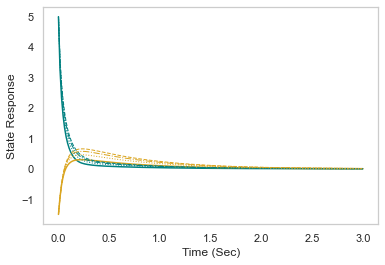

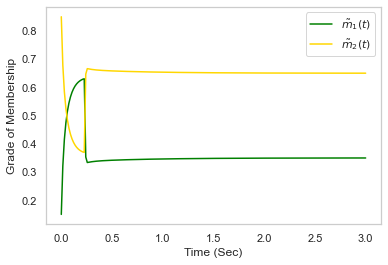

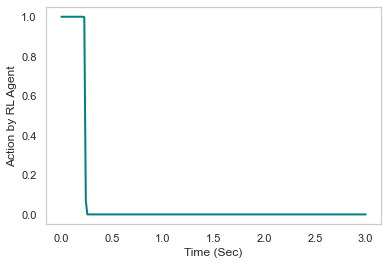

In [4]:
x_init = torch.tensor([5, -1.5], dtype = torch.float32)
t = np.linspace(0, 3, 200)
t = torch.tensor(t, dtype = torch.float32)
y = odeint(numerical_model_simu, x_init, t)

u_simu = actor.forward(torch.tensor(y, dtype=torch.float32)).detach().numpy()
control_input_array = control_simu(y)
y_plain = odeint(numerical_model_simu_plain, x_init, t, args=(0., ))
control_input_array_plain = control_simu_plain(y_plain, 0.)




plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

plt.plot(t, y[:, 0], 'teal', linewidth=1.5)
plt.plot(t, y[:, 1], 'goldenrod', linewidth=1.5)
plt.plot(t, y_plain[:, 0], 'teal', linewidth=1, linestyle='--')
plt.plot(t, y_plain[:, 1], 'goldenrod', linewidth=1, linestyle='--')

y_plain = odeint(numerical_model_simu_plain, x_init, t, args=(0.2, ))
plt.plot(t, y_plain[:, 0], 'teal', linewidth=1, linestyle='-.')
plt.plot(t, y_plain[:, 1], 'goldenrod', linewidth=1, linestyle='-.')

y_plain = odeint(numerical_model_simu_plain, x_init, t, args=(0.5, ))
plt.plot(t, y_plain[:, 0], 'teal', linewidth=1, linestyle=':')
plt.plot(t, y_plain[:, 1], 'goldenrod', linewidth=1, linestyle=':')
plt.xlabel('Time (Sec)')
plt.ylabel('State Response')

m1_array = np.zeros_like(t)
for i in range(len(t)):
    state = y[i,:]
    m1_array[i] = mfs_cal(state, actor)

m2_array = 1 - m1_array
plt.figure()
plt.plot(t, m1_array, 'green', linewidth=1.5, label = r'$\tilde{m}_1(t)$')
plt.plot(t, m2_array, 'gold', linewidth=1.5, label = r'$\tilde{m}_2(t)$')
plt.xlabel('Time (Sec)')
plt.ylabel('Grade of Membership')
plt.legend()
#plt.savefig('grades.jpg', dpi=(5000, 5000))
#Image.open('grades.png').save('grades.jpg','JPEG')


plt.figure()
plt.plot(t, u_simu, 'teal', linewidth=2)
plt.xlabel('Time (Sec)')
plt.ylabel('Action by RL Agent')

In [5]:
Img=Image.open('grades.png')
Img.show()

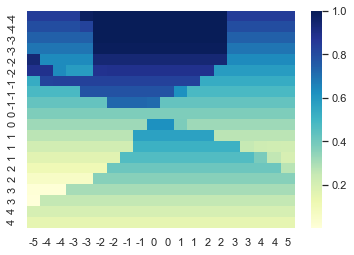

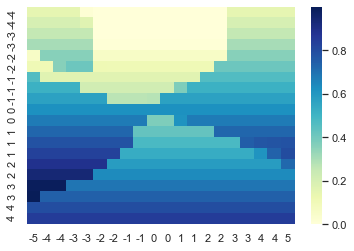

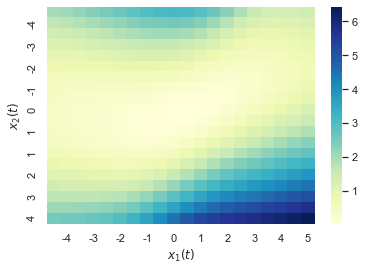

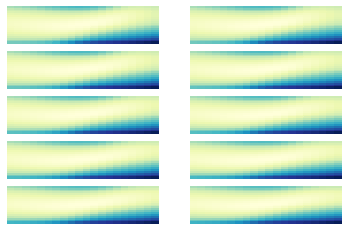

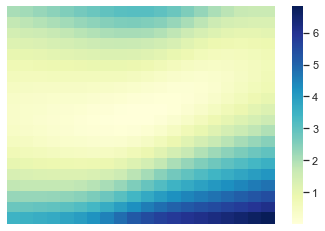

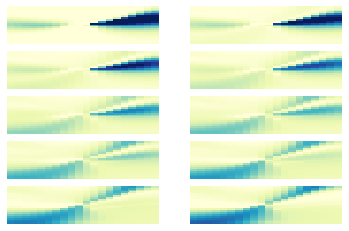

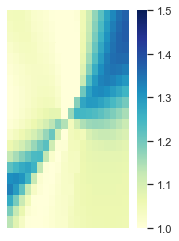

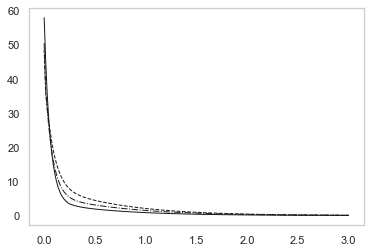

In [6]:
S = np.array([[1, 0], [0, 1]])
R = 0

x_grid = np.linspace(-5, 5, 20)
y_grid = np.linspace(-4, 4, 20)
value_grid = np.zeros((len(x_grid), len(y_grid)))
m1_grid = np.zeros((len(x_grid), len(y_grid)))
for i, x_value in enumerate(x_grid):
    for j, y_value in enumerate(y_grid):
        state = [x_value, y_value]
        m1_grid[i, j] = mfs_cal(state, actor)
m2_grid = 1 - m1_grid
plt.figure()
sns.heatmap(m1_grid, cmap="YlGnBu", xticklabels=np.round(x_grid).astype(int),
                                            yticklabels=np.round(y_grid).astype(int))
plt.figure()
sns.heatmap(m2_grid, cmap="YlGnBu", xticklabels=np.round(x_grid).astype(int),
                                            yticklabels=np.round(y_grid).astype(int))


for i, x_value in enumerate(x_grid):
    for j, y_value in enumerate(y_grid):
        init_position = [x_value, y_value]
        value_grid[i, j] = value_cal(init_position)

z_grid = np.linspace(0, 1, 10)
value_grid_plain = np.zeros((len(x_grid), len(y_grid),  len(z_grid)))
for k, z_value in enumerate(z_grid):
    for i, x_value in enumerate(x_grid):
        for j, y_value in enumerate(y_grid):
            init_position = [x_value, y_value]
            value_grid_plain[i, j, k] = value_cal_plain(init_position, z_value)

plt.figure()
ax = sns.heatmap(value_grid.T, cmap="YlGnBu", xticklabels=np.round(x_grid).astype(int),
                                            yticklabels=np.round(y_grid).astype(int))


for ind, label in enumerate(ax.get_xticklabels()):
    if (ind+1) % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
    # if ind == len(x_grid)-1:
    #     label.set_visible(True)

for ind, label in enumerate(ax.get_yticklabels()):
    if (ind+1) % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.xlabel('$x_1(t)$')
plt.ylabel('$x_2(t)$')


plt.figure()
for i, _ in enumerate(z_grid):
    plt.subplot(5, 2, i+1)
    ratio = value_grid_plain[:, :, i].T
    sns.heatmap(ratio, cmap="YlGnBu", xticklabels=[], yticklabels=[], cbar=False)

plt.figure()
sns.heatmap(ratio, cmap="YlGnBu", xticklabels=[], yticklabels=[])

plt.figure()
for i, _ in enumerate(z_grid):
    if i < len(z_grid)-1:
        plt.subplot(5, 2, i+1)
        ratio = value_grid_plain[:, :, i] / value_grid
        sns.heatmap(ratio.T, cmap="YlGnBu", xticklabels = [], yticklabels = [], cbar=False, vmin=1, vmax=1.5)
    else:
        plt.subplot(5, 2, i + 1)
        ratio = value_grid_plain[:, :, i] / value_grid
        sns.heatmap(ratio.T, cmap="YlGnBu", xticklabels = [], yticklabels = [], cbar=False, vmin=1, vmax=1.5)



plt.figure()
plt.subplot(1, 2, 1)
sns.heatmap(ratio, cmap="YlGnBu", xticklabels = [], yticklabels = [], cbar=True, vmin=1, vmax=1.5)



plt.figure()
plt.plot(t, control_input_array, 'k', linewidth=1)
plt.plot(t, control_input_array_plain, 'k--', linewidth=1)
control_input_array_plain = control_simu_plain(y_plain, 0.2)
plt.plot(t, control_input_array_plain, 'k-.', linewidth=1)

# plt.figure()
# plt.plot(return_in_episode)
# plt.xlabel('Episode')
# plt.ylabel('Return Episode')

In [9]:
critic

CriticNet(
  (fc1): Linear(in_features=3, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

In [10]:
torch.tensor([3, 4], dtype = torch.float32)

tensor([3., 4.])

In [11]:
actor.fc1.weight.data.dtype

torch.float32

In [12]:
actor.forward(torch.tensor([3, 4], dtype = torch.float32))

tensor([1.], grad_fn=<SigmoidBackward0>)